In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np

In [4]:
# подключение обычное и для юзера с правами на создание и редактирование таблиц
# ОСТОРОЖНО


connection_default = {'host': '',
                      'database':'',
                      'user':'', 
                      'password':''}
                            
connection_test = dict(database='',
                  host='',
                  user='',
                  password='')

In [4]:
q = '''
    SELECT COUNT(1)
    FROM ldn_listings 
    '''


listings_count = ph.read_clickhouse(query=q, connection=connection_default)
listings_count

,count()
0,85207


In [5]:
# задача 6.2
# Выгрузите из таблицы данные о цене в зависимости от типа жилья. Ограничение поставьте на 1000 строк. 
# Результат должен быть отсортирован по возрастанию id.
# Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль  цены.

q = '''
    SELECT  room_type, toFloat64OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM ldn_listings
    GROUP BY room_type, price, id
    ORDER BY id
    LIMIT 1000
    '''

listings_price_type = ph.read_clickhouse(query=q, connection=connection_default)
listings_price_type

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [6]:
price_type = listings_price_type.groupby('room_type').quantile(q=0.75)
price_type

,price
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


In [7]:
# задача 6.3
# К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). 
# В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.
# Построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.


q1 = '''
    SELECT  room_type, 
        toFloat64OrNull(replaceRegexpAll(price, '[$,]', '')) as price, 
        toFloat32OrNull(review_scores_rating) as review_scores_rating
    FROM ldn_listings
    WHERE review_scores_rating != 0
    GROUP BY room_type, price, id, review_scores_rating
    ORDER BY id
    LIMIT 1000
    '''

listings_price_type_rate = ph.read_clickhouse(query=q1, connection=connection_default)
listings_price_type_rate

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [8]:
price_type_rate = listings_price_type_rate.groupby('room_type').mean(['price', 'review_scores_rating'])
price_type_rate = price_type_rate.reset_index()
price_type_rate

,room_type,price,review_scores_rating
0,Entire home/apt,135.882957,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642436,94.766205
3,Shared room,21.000000,90.000000


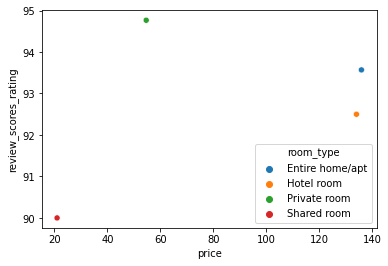

In [9]:
sns.scatterplot(data=price_type_rate, x='price', y='review_scores_rating', hue='room_type')

In [10]:
# задача 6.4
# Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления 
# (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите:

# host_id – идентификатор хозяина
# host_verifications – какими способами хост подтвердил свой профиль
# Затем обработайте столбец host_verifications:

# В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). 
# Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
# "['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']
# Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации
# Сколько хозяев подтвердили профиль с помощью аккаунта Google?


In [11]:
q2 = '''
    select distinct host_id, host_verifications
    from ldn_listings
    where experiences_offered != 'none'
    '''

events = ph.read_clickhouse(query=q2, connection=connection_default)
events

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [12]:
# сначала убираем скобки и лишние кавычки напрямую в строках, затем сплитим (соединяем) через запятую, чтобы вручную сделать строки
# потом "взрываем" и считаем каунт по каждому элементу
events.host_verifications.apply(lambda x: x.strip('[').strip(']').replace("'",'').split(', ')) \
                         .explode().value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [13]:
# задача 6.5
# Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count. 

q3 = '''
    select neighbourhood_cleansed, experiences_offered, count(id) as experiences_count
    from default.ldn_listings
    where experiences_offered != 'none'
    group by neighbourhood_cleansed, experiences_offered
    order by experiences_count desc
    limit 100
    '''

events_count = ph.read_clickhouse(query=q3, connection=connection_default)
events_count

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


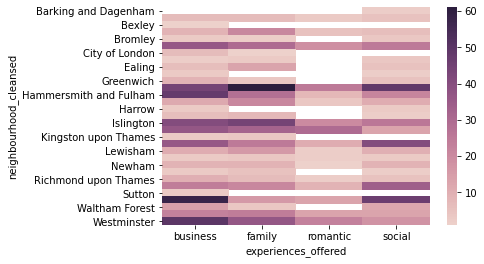

In [14]:
pivot = events_count.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
sns.heatmap(pivot, cmap=sns.cubehelix_palette(as_cmap=True))

In [15]:
pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


In [16]:
# задача 6.6
# Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 
# Необходимые для составления запроса столбцы:

# room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
# price – цена за ночь 
# experiences_offered – вид доступного впечатления (оставить не 'none')

# Далее постройте два графика, используя distplot из библиотеки seaborn

In [4]:
q4 = '''
    select room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr 
    from ldn_listings
    where experiences_offered != 'none'
    group by room_type, price_corr
    '''

prices_night = ph.read_clickhouse(query=q4, connection=connection_default)
prices_night

,room_type,price_corr
0,Entire home/apt,89.0
1,Private room,93.0
2,Entire home/apt,157.0
3,Entire home/apt,70.0
4,Private room,66.0
...,...,...
287,Entire home/apt,390.0
288,Private room,57.0
289,Entire home/apt,59.0
290,Private room,250.0


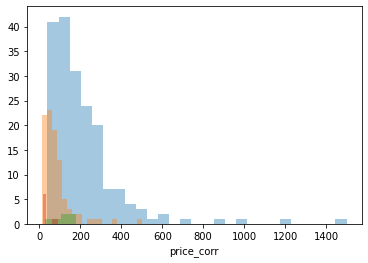

In [11]:
sns.distplot(prices_night[prices_night['room_type'] == 'Entire home/apt'].price_corr, kde=False)
sns.distplot(prices_night[prices_night['room_type'] == 'Private room'].price_corr, kde=False)
sns.distplot(prices_night[prices_night['room_type'] == 'Hotel room'].price_corr, kde=False)
sns.distplot(prices_night[prices_night['room_type'] == 'Shared room'].price_corr, kde=False)

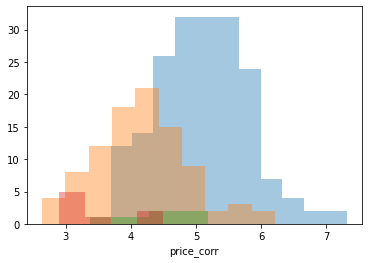

In [10]:
sns.distplot(np.log(prices_night[prices_night['room_type'] == 'Entire home/apt'].price_corr), kde=False)
sns.distplot(np.log(prices_night[prices_night['room_type'] == 'Private room'].price_corr), kde=False)
sns.distplot(np.log(prices_night[prices_night['room_type'] == 'Hotel room'].price_corr), kde=False)
sns.distplot(np.log(prices_night[prices_night['room_type'] == 'Shared room'].price_corr), kde=False)

In [ ]:
# задача 6.7
# Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года
# Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) 
# в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X)
# Датафрейм должен быть отсортирован по годам

In [22]:
q5 = '''
    select room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr, first_review
    from default.ldn_listings
    where first_review > '2010-01-01'
    limit 1000
    '''

data_since_jan_2010 = ph.read_clickhouse(query=q5, connection=connection_default)
data_since_jan_2010

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [23]:
data_since_jan_2010['first_review'] = pd.to_datetime(data_since_jan_2010['first_review'])

data_since_jan_2010.first_review = data_since_jan_2010.first_review.dt.year
data_since_jan_2010

# data_since_jan_2010.dtypes

,room_type,price_corr,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


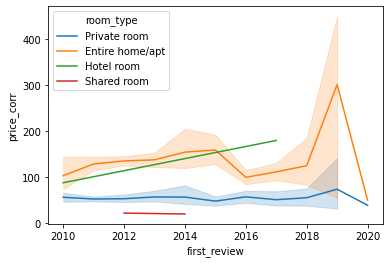

In [24]:
sns.lineplot(data=data_since_jan_2010, x='first_review', y='price_corr', hue='room_type')